In [33]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.spatial.distance import cdist
import wfdb
import matplotlib.ticker as mtick

In [90]:

idx = 6
record = wfdb.rdrecord(f'/Volumes/Ultra Touch/Data/physionet/chfdb/chf0{idx}')
signal = record.p_signal[:,1]
signal = signal[-91000:-89600]

signal2 = np.loadtxt("/Users/tgermain/Documents/code/tsgraph2/HQ.txt")

import statsmodels.api as sm
airpass = sm.datasets.get_rdataset("AirPassengers", "datasets")
signal3 = airpass.data["value"].values


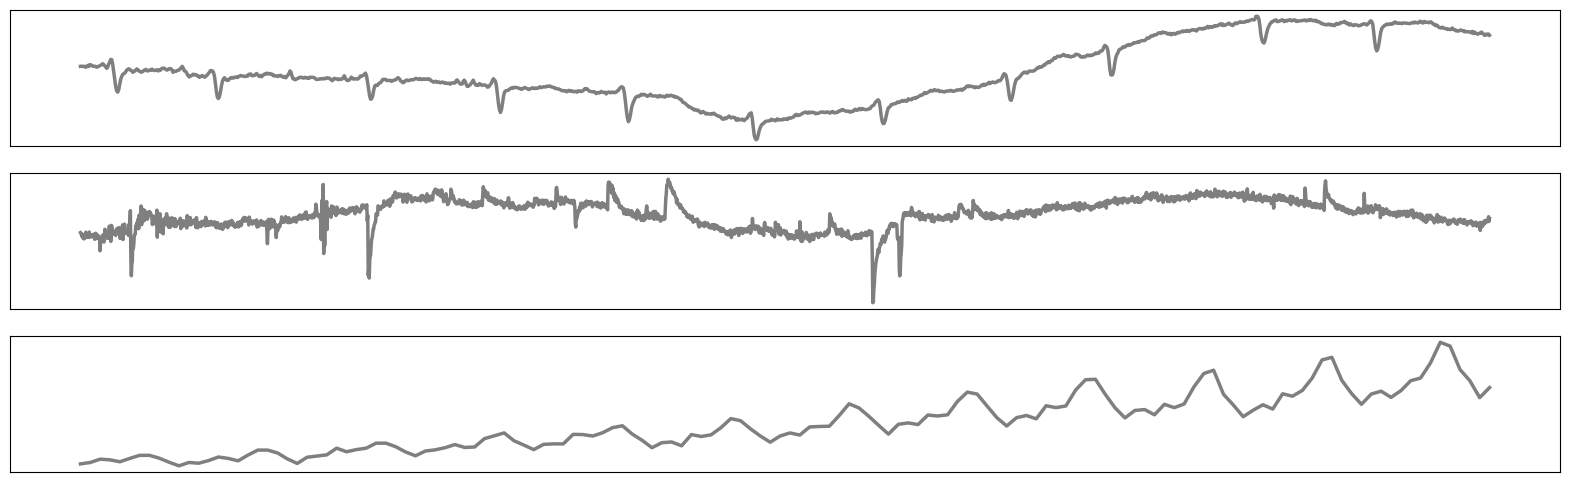

In [106]:
fig,axs = plt.subplots(3,1,figsize = (20,6))

axs[0].plot(signal, color = "black", alpha = 0.5, linewidth = 2.5)
axs[1].plot(signal2[::15], color = "black", alpha = 0.5 , linewidth = 2.5)
axs[2].plot(signal3, color = "black", alpha = 0.5 , linewidth = 2.5)

for ax in axs: 
    ax.set_xticks([])
    ax.set_yticks([])

In [34]:
def z_matrixprofile(signal,wlen): 
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    X = X-X_bar
    X = X/np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen): 
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX

In [35]:
def z_distanceprofile(signal,subsequence): 
    wlen = subsequence.shape[0]
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    X = X-X_bar
    X = X/np.linalg.norm(X,axis=1).reshape(-1,1)
    sub = subsequence.copy()
    sub = sub-np.mean(sub)
    sub = sub/np.linalg.norm(sub)
    sub = sub.reshape(1,-1)
    distance_profile = np.linalg.norm(X-sub,axis=1)
    return distance_profile


In [36]:
def lt_matrixprofile(signal,wlen):
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    t = np.arange(wlen)
    t_bar = np.mean(t)
    a = (np.sum(X*t,axis=1).reshape(-1,1)/wlen - X_bar*t_bar)/np.std(t)**2
    b = X_bar - a*t_bar
    X = X- (a*t +b)
    X /= np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen):
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX

In [37]:
def lt_distanceprofile(signal,subsequence): 
    wlen = subsequence.shape[0]
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    t = np.arange(wlen)
    t_bar = np.mean(t)
    a = (np.sum(X*t,axis=1).reshape(-1,1)/wlen - X_bar*t_bar)/np.std(t)**2
    b = X_bar - a*t_bar
    X = X- (a*t +b)
    X /= np.linalg.norm(X,axis=1).reshape(-1,1)
    sub = subsequence.copy()
    a_sub = (np.sum(sub*t)/wlen -t_bar*np.mean(sub))/np.std(t)**2
    b_sub = np.mean(sub) - a_sub * t_bar
    sub = sub - (a_sub * t + b_sub)
    sub = sub/np.linalg.norm(sub)
    sub = sub.reshape(1,-1)
    distance_profile = np.linalg.norm(X-sub,axis=1)
    return distance_profile

# ECG Experiment

In [38]:
def _R_label(idx_lst: list,size:int,margin = 10):
    """_summary_

    Args:
        idx_lst (list): annotation
        size (int): final size of label
        margin (int, optional): margin in number of points. Defaults to 10.
    """
    label_mask = np.zeros(size)
    label_arr = []
    for idx in idx_lst: 
        start = max(0,idx-margin)
        end = min(size,idx+margin)
        rng = np.arange(start,end)
        label_mask[rng]=1
        label_arr.append([start,end])
    return label_mask.astype(int), np.array(label_arr)

In [39]:
def profile_score(r_idx_lst, profile,margin=10,n_threshold=201): 
    r_mask,r_arr = _R_label(r_idx_lst,profile.shape[0],margin)
    threshold = np.linspace(0,2,n_threshold)
    score = np.zeros((n_threshold,2))
    sort_idxs = np.argsort(profile)
    min_dist = profile[sort_idxs[0]]
    threshold_idx = np.where(min_dist<threshold)[0][0]

    starts = r_arr[:,0]
    ends = []
    if starts[0]!=0: 
        ends.append(0)
    ends += r_arr[:,1].tolist()
    if ends[-1] == r_mask.shape[0]: 
        ends.pop()
    ends = np.array(ends)

    n_tp = starts.shape[0]
    n_fp = ends.shape[0]
    tp_arr = np.zeros(n_tp)
    fp_arr = np.zeros(n_fp)
    count = [0,0]


    for idx in sort_idxs: 
        dist = profile[idx]
        if dist>threshold[threshold_idx]:
            next_threshold_idx = np.where(dist<threshold)[0][0]
            for i in np.arange(threshold_idx,next_threshold_idx): 
                score[i] = count
            threshold_idx = next_threshold_idx
            
        if r_mask[idx]==1: 
            l_idx = np.where(idx>=starts)[0][-1]
            if tp_arr[l_idx] == 0: 
                count[1]+=1/n_tp
                tp_arr[l_idx] =1 
        
        else: 
            l_idx = np.where(idx>=ends)[0][-1]
            if fp_arr[l_idx] == 0: 
                count[0]+=1/n_fp
                fp_arr[l_idx] = 1

    score[threshold_idx:,:] = count
    return score

In [40]:
wlen = 20000
z_score = []
lt_score = []
subjects = [100, 101, 103, 117, 122]
#subjects = [103]
s_counts = 0
for subject in subjects: 
    path = f"/Volumes/Ultra Touch/Data/physionet/mitdb/{subject}"
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path,"atr")
    signal = record.p_signal[:,1]
    size = signal.shape[0]
    s_counts += size//wlen
    for i in range(size//wlen): 
        tsignal = signal[i*wlen:(i+1)*wlen]
        r_idx_lst = []
        for idx in ann.sample: 
            if (idx >= i*wlen)*(idx<(i+1)*wlen): 
                r_idx_lst.append(idx)
        r_idx_lst = np.array(r_idx_lst) - i*wlen
        subsequence = tsignal[r_idx_lst[0]:r_idx_lst[1]][:-50]
        r_idx_lst = r_idx_lst[r_idx_lst<=wlen-subsequence.shape[0]+1]
        z_profile = z_distanceprofile(tsignal,subsequence)
        t_z_score = profile_score(r_idx_lst,z_profile,margin=40,n_threshold=201)
        z_score.append(t_z_score)
        lt_profile = lt_distanceprofile(tsignal,subsequence)
        t_lt_score = profile_score(r_idx_lst,lt_profile,margin=40,n_threshold=201)
        lt_score.append(t_lt_score)  

lt_score = np.mean(np.array(lt_score),axis=0)
z_score = np.mean(np.array(z_score),axis=0)   


In [41]:
lt_fpr,lt_tpr = np.unique(lt_score,axis=0).T
auc_lt = np.sum(np.diff(lt_fpr)*lt_tpr[1:])

z_fpr,z_tpr = np.unique(z_score,axis=0).T
auc_z = np.sum(np.diff(z_fpr)*z_tpr[1:])


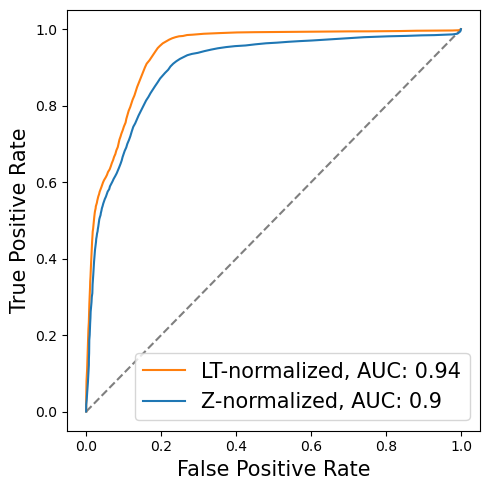

In [42]:
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
plt.plot(*np.unique(lt_score,axis=0).T,label = f"LT-normalized, AUC: {np.round(auc_lt,2)}", color = "tab:orange")
plt.plot(*np.unique(z_score,axis=0).T, label = f"Z-normalized, AUC: {np.round(auc_z,2)}", color = "tab:blue")
ax.set_xlabel("False Positive Rate",fontsize =15)
ax.set_ylabel("True Positive Rate",fontsize =15)
ax.legend(fontsize =15)
fig.tight_layout()

In [43]:
80/360

0.2222222222222222

# Synthetic Data Experiment

In [44]:
def plot_signal_profil(signal,wlen,Pa,IDXa,Pz,IDXz,TrueIDX=None):
    idxa = np.argmin(Pa)
    idxz = np.argmin(Pz)
    fig,axs = plt.subplots(3,1,sharex=True,figsize = (20,6))

    if TrueIDX is not None: 
        for pos in TrueIDX:
            for i in range(3): 
                axs[i].axvspan(pos,pos+wlen,facecolor = "blue", alpha=0.1,label = "True position")

    axs[0].plot(signal, color = "black", alpha = 0.3)
    time = np.arange(idxa,idxa+wlen)
    axs[0].plot(time,signal[time],color = "tab:orange",label= "LT-Motif")
    idxa_bis = IDXa[idxa]
    time = np.arange(idxa_bis,idxa_bis+wlen)
    axs[0].plot(time,signal[time],color = "tab:orange")

    time = np.arange(idxz,idxz+wlen)
    axs[0].plot(time,signal[time],color = "tab:blue", label = "Z-Motif")
    idxz_bis = IDXz[idxz]
    time = np.arange(idxz_bis,idxz_bis+wlen)
    axs[0].plot(time,signal[time],color = "tab:blue")

    axs[1].plot(Pa, color = "black", alpha = 0.3)
    axs[1].scatter([idxa,idxa_bis],[Pa[idxa],Pa[idxa_bis]],100,color = "tab:orange", marker = "X",label = "LT-Start")

    axs[2].plot(Pz, color = "black",alpha = 0.3)
    axs[2].scatter([idxz,idxz_bis],[Pz[idxz],Pz[idxz_bis]],100,color = "tab:blue", marker = "X", label = "Z-Start")


    axs[0].set_title("Time-series",fontsize=20)
    axs[1].set_title("LT-normalized matrix-profile",fontsize=20)
    axs[2].set_title("Z-normalized matrix-profile",fontsize=20)

    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0].legend(by_label.values(), by_label.keys(),fontsize = 15)

    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].legend([handles[-1]],[labels[-1]],fontsize = 15)
    
    handles, labels = axs[2].get_legend_handles_labels()
    axs[2].legend([handles[-1]],[labels[-1]],fontsize = 15)

    fig.tight_layout()
    return fig,axs

In [45]:
from synthetic_signal import SignalGenerator
from metric import SingleEventScore

In [46]:
WLEN = 120
M_WLEN =100
N_SIGNALS = 100

(<Figure size 2000x600 with 3 Axes>,
 array([<Axes: title={'center': 'Time-series'}>,
        <Axes: title={'center': 'LT-normalized matrix-profile'}>,
        <Axes: title={'center': 'Z-normalized matrix-profile'}>],
       dtype=object))

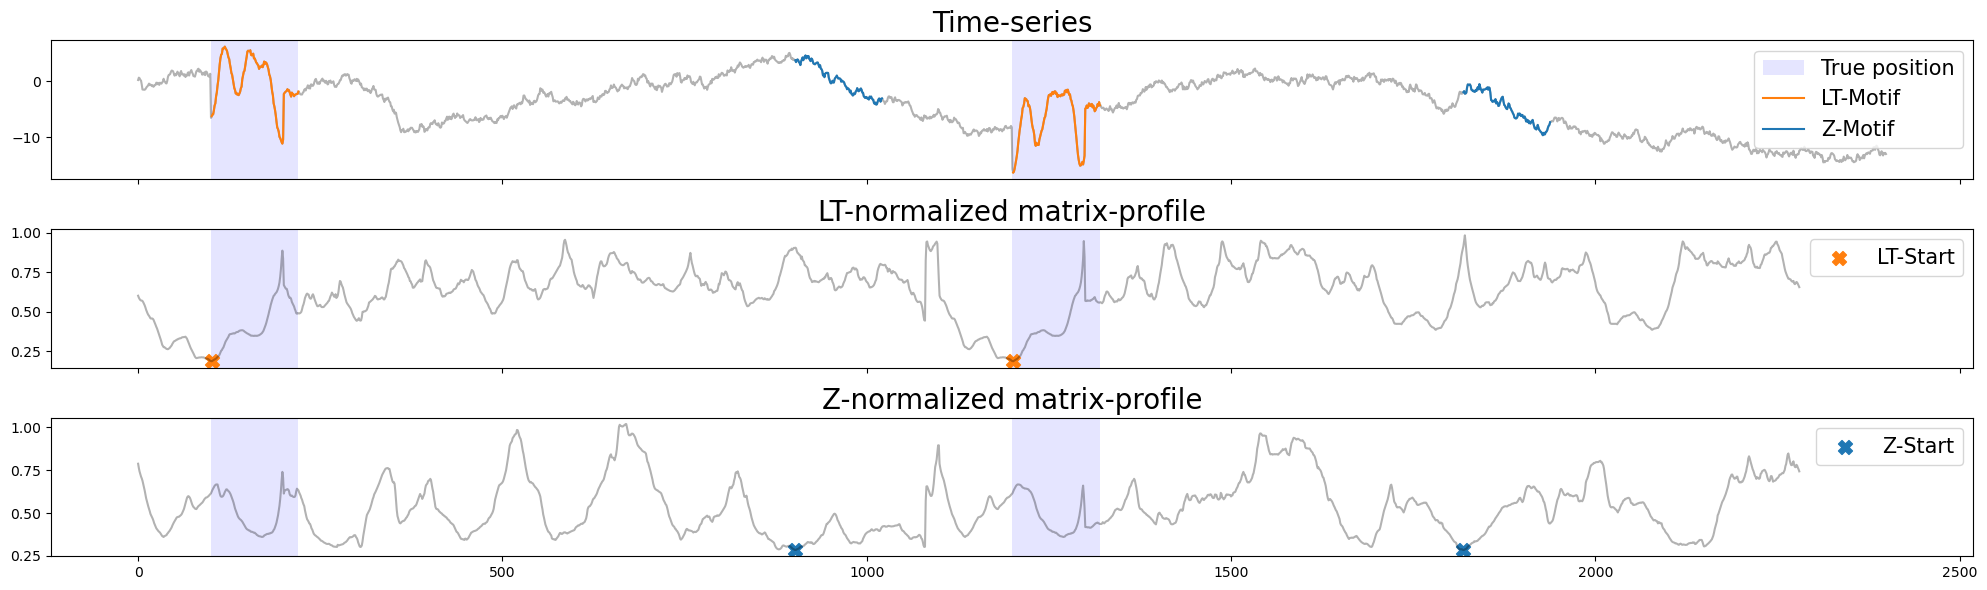

In [57]:
np.random.seed(8)
sg = SignalGenerator(1,M_WLEN,1,4,"Sin",sparsity=10,min_rep=2,max_rep=2,walk_amplitude=0.3,noise_amplitude=0.1)
sg.generate()
signal = sg.signal_

Pz,IDXz= z_matrixprofile(signal,WLEN)
Pa,IDXa = lt_matrixprofile(signal,WLEN)

plot_signal_profil(signal,WLEN,Pa,IDXa,Pz,IDXz,list(zip(*sg.positions_[0]))[0])

In [281]:
dataset = []
labels = []
for i in range(N_SIGNALS): 
    np.random.seed(i)
    signal, label = sg.generate()
    dataset.append(signal)
    labels.append(label)

In [282]:
def prediction_mask(L,wlen,P,IDX): 
    idx1 = np.argmin(P)
    idx2 = IDX[idx1]
    mask = np.zeros(L)
    mask[idx1:idx1+wlen] = 1
    mask[idx2:idx2+wlen] = 1
    return mask

In [283]:
ses = SingleEventScore()
final_score = []
for method in [z_matrixprofile,lt_matrixprofile]:
    t_scores = []
    for signal,label in zip(dataset,labels): 
        P,IDX = method(signal,WLEN)
        L = signal.shape[0]
        mask = prediction_mask(L,WLEN,P,IDX)
        t_scores.append(ses.all_score(label.reshape(-1),mask))
    avg_score = []
    for lst in list(zip(*t_scores)):
        avg_score.append(np.mean(lst,axis=0))
    final_score.append(avg_score)

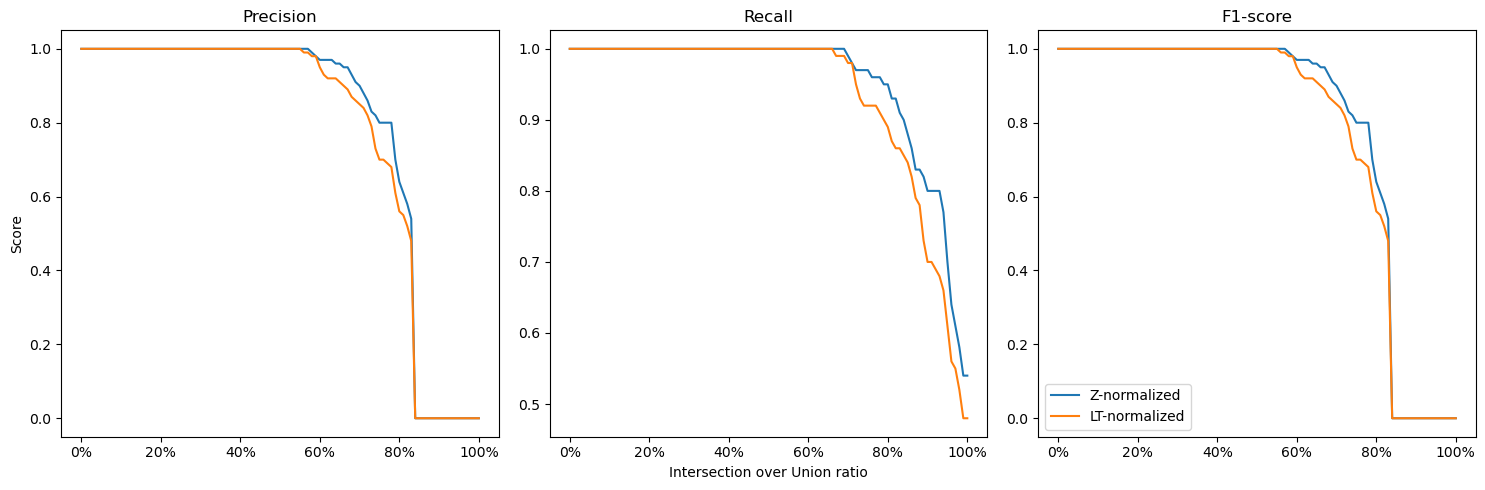

In [284]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
labels = ["Z-normalized","LT-normalized"]

for i in range(2): 
    for j in range(3):
        axs[j].plot(final_score[i][j], label = labels[i])
axs[0].set_title("Precision")
axs[0].set_ylabel("Score")
axs[1].set_title("Recall")
axs[1].set_xlabel("Intersection over Union ratio")
axs[2].set_title("F1-score")
axs[2].legend()
for ax in axs: 
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
fig.tight_layout()

### SCORE FROM RANDOM WALK VARIANCE

In [374]:
LMBDS = np.linspace(0,0.3,51)
WLEN = 120
M_WLEN =100
N_SIGNALS = 100
THESHOLD_RATIO = M_WLEN/WLEN *0.5

final_score =[]

for lmbd in LMBDS: 

    #generate dataset
    dataset = []
    labels = []
    sg = SignalGenerator(1,M_WLEN,1,4,"Sin",sparsity=10,min_rep=2,max_rep=2,walk_amplitude=lmbd,noise_amplitude=0.1)
    for i in range(N_SIGNALS): 
        signal, label = sg.generate()
        dataset.append(signal)
        labels.append(label)

    #get score
    ses = SingleEventScore()
    threshold_score = []
    for method in [z_matrixprofile,lt_matrixprofile]:
        t_scores = []
        for signal,label in zip(dataset,labels): 
            P,IDX = method(signal,WLEN)
            L = signal.shape[0]
            mask = prediction_mask(L,WLEN,P,IDX)
            t_scores.append(ses.score(label.reshape(-1),mask,THESHOLD_RATIO))
        threshold_score.append(np.mean(t_scores,axis=0))
    final_score.append(threshold_score)


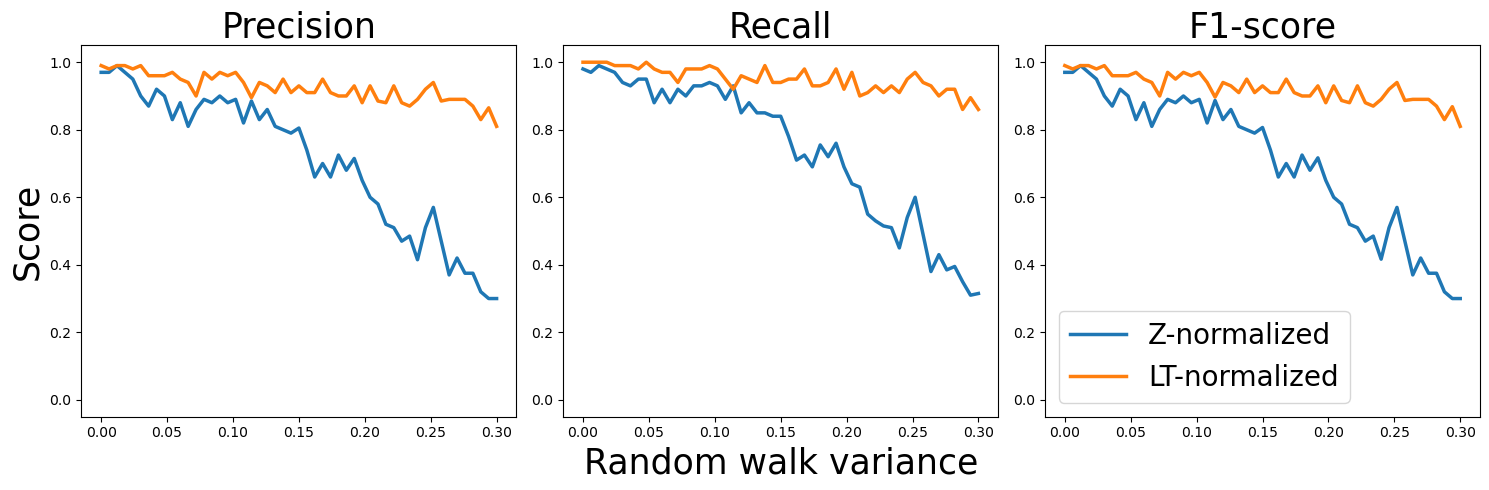

In [375]:
plot_score = list(zip(*final_score))

fig, axs = plt.subplots(1,3, figsize = (15,5))
labels = ["Z-normalized","LT-normalized"]
colors = ["tab:blue", "tab:orange"]

for i, scores in enumerate(plot_score): 
    scores = np.array(scores)
    for j,line in enumerate(scores.T):
        axs[j].plot(LMBDS,line, label = labels[i],linewidth=2.5)
axs[0].set_title("Precision",fontsize = 25)
axs[0].set_ylabel("Score",fontsize = 25)
axs[1].set_title("Recall",fontsize = 25)
axs[1].set_xlabel("Random walk variance",fontsize = 25)
axs[2].set_title("F1-score",fontsize = 25)
axs[2].legend(fontsize = 20)

for ax in axs:
    ax.set_ylim(-0.05,1.05)

fig.tight_layout()

### ACCURACY FROM random walk


In [400]:
def get_prediction(P,IDX,wlen): 
    idx1 = np.argmin(P)
    idx2 = IDX[idx1]
    if idx1< idx2:
        return [[idx1,idx1+wlen],[idx2,idx2+wlen]]
    else:
        return [[idx2,idx2+wlen],[idx1,idx1+wlen]]

In [401]:
def unit_score(R,P,threshold): 
    count = 0
    for (rs,re), (ps,pe) in zip(R,P):
        s = max(rs,ps)
        e = min(re,pe)
        if e-s >= threshold *(re-rs): 
            count +=1
    if count ==2: 
        return 1
    else: 
        return 0 


In [417]:
LMBDS = np.linspace(0,0.5,51)
WLEN = 120
M_WLEN =100
N_SIGNALS = 200
THESHOLD_RATIO = 0.5

final_score =[]

for lmbd in LMBDS: 

    #generate dataset
    dataset = []
    labels = []
    sg = SignalGenerator(1,M_WLEN,1,4,"Sin",sparsity=10,min_rep=2,max_rep=2,walk_amplitude=lmbd,noise_amplitude=0.1)
    for i in range(N_SIGNALS): 
        signal, label = sg.generate()
        dataset.append(signal)
        rss = list(zip(*sg.positions_[0]))[0]
        label = []
        for rs in rss: 
            label.append([rs,rs+M_WLEN])
        labels.append(label)

    #get score
    ses = SingleEventScore()
    threshold_score = []
    for method in [z_matrixprofile,lt_matrixprofile]:
        t_scores = []
        for signal,label in zip(dataset,labels): 
            P,IDX = method(signal,WLEN)
            L = signal.shape[0]
            pred = get_prediction(P,IDX,WLEN)
            
            t_scores.append(unit_score(label,pred,THESHOLD_RATIO))
        threshold_score.append(np.mean(t_scores,axis=0))
    final_score.append(threshold_score)

final_score = np.array(final_score)

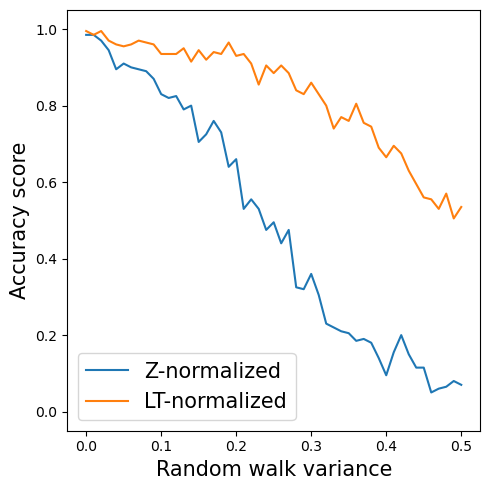

In [419]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(LMBDS,final_score[:,0],label = "Z-normalized", color = "tab:blue")
ax.plot(LMBDS,final_score[:,1],label = "LT-normalized", color = "tab:orange")
ax.set_xlabel("Random walk variance",fontsize=15)
ax.set_ylabel("Accuracy score",fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim(-0.05,1.05)
fig.tight_layout()

In [ ]:
wlen = 120
t = np.arange()